In [56]:
#Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import create_engine, inspect, func

In [57]:
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt


In [58]:
import pandas as pd
from pandas import DataFrame
import sqlite3
import numpy as np
from sqlalchemy import distinct
from sqlalchemy import func



**Step 3 - Climate Analysis and Exploration**

In [59]:
# Create engine 
from sqlalchemy import event
from sqlalchemy import exc
import os

engine = create_engine("sqlite:///hawaii.sqlite",echo=False )

@event.listens_for(engine, "connect")
def connect(dbapi_connection, connection_record):
    connection_record.info['pid'] = os.getpid()

@event.listens_for(engine, "checkout")
def checkout(dbapi_connection, connection_record, connection_proxy):
    pid = os.getpid()
    if connection_record.info['pid'] != pid:
        connection_record.connection = connection_proxy.connection = None
        raise exc.DisconnectionError(
                "Connection record belongs to pid %s, "
                "attempting to check out in pid %s" %
                (connection_record.info['pid'], pid)
        )


In [60]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [61]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [62]:
# Print all of the classes mapped to the Base
Base.classes.keys()


['measurement', 'station']

In [63]:
Measurement = Base.classes.measurement
Station = Base.classes.station
conn = engine.connect()


In [64]:
#inspect data
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR(255)
date VARCHAR(255)
prcp INTEGER
tobs INTEGER


In [65]:
# Create a session
session = Session(engine)

In [66]:
inspector.get_table_names()

['measurement', 'station']

In [67]:
#identify last date of mesurement
some_list=conn.execute("select date from measurement").fetchall()
last_date=some_list[-1]
print(last_date)

('2017-08-23',)


In [68]:
#set up dates of trip

import datetime as dt
query_date = dt.date(2011, 4, 8) - dt.timedelta(days=15)

print("Start date: ", dt.date(2011, 4, 8) ," "," Finish Date: " , query_date )


Start date:  2011-04-08    Finish Date:  2011-03-24


**Precipitation Analysis**


In [69]:
#create dataframe
results = session.query( Measurement.date, Measurement.prcp).\
     order_by(Measurement.date.desc()).all()
plot_data_df=pd.DataFrame(results)
plot_df=plot_data_df.groupby(['date'])['prcp'].mean().reset_index().tail(365)
plot=plot_df.rename(columns={"prcp":"Precipitation"})
date_list=plot['date']
prcp_list=plot['Precipitation']
random_list=np.random.choice(date_list,8)
random_list_sort=np.sort(random_list)[::-1]
plot.head()


,date,Precipitation
2427,2016-08-24,1.332857
2428,2016-08-25,0.077143
2429,2016-08-26,0.016667
2430,2016-08-27,0.053333
2431,2016-08-28,0.516667


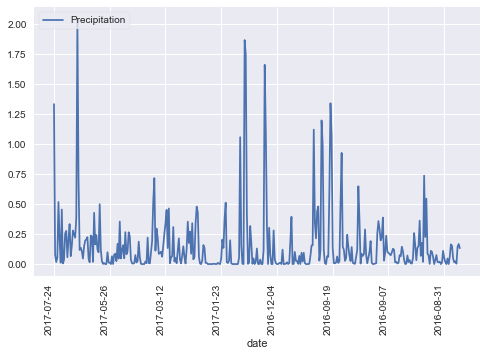

In [70]:
#creat plot
new_df=plot_df.plot(x=date_list,subplots=True)
#ax = fig.add_subplot(111)
#fig, ax = plt.subplots(111)
#ax.set_xticks(date)
xlabels=random_list_sort
plt.xticks(np.arange(0,365,50),xlabels, rotation = 'vertical')
plt.xlabel("date")
plt.legend(labels=['Precipitation'],loc='upper left',frameon=True)
plt.show()

**Station Analysis**


In [71]:
#find number of stations
stations=session.query(func.count(distinct(Measurement.station))).one()
print(stations)


(9,)


In [72]:
#find station with the biggest number of the observtions
observations=session.query(Measurement.station,func.count(Measurement.tobs)).\
             group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()

print(observations)



('USC00519281', 2772)


In [73]:
# print data for the sattion with the most observations done
temps=session.query(Measurement.station,Measurement.tobs,func.count(Measurement.tobs)).group_by(Measurement.tobs).\
      filter(Measurement.station == 'USC00519281').all()
print(temps)

[('USC00519281', 54, 1), ('USC00519281', 56, 4), ('USC00519281', 57, 6), ('USC00519281', 58, 6), ('USC00519281', 59, 5), ('USC00519281', 60, 15), ('USC00519281', 61, 19), ('USC00519281', 62, 37), ('USC00519281', 63, 33), ('USC00519281', 64, 41), ('USC00519281', 65, 71), ('USC00519281', 66, 80), ('USC00519281', 67, 111), ('USC00519281', 68, 143), ('USC00519281', 69, 193), ('USC00519281', 70, 227), ('USC00519281', 71, 265), ('USC00519281', 72, 290), ('USC00519281', 73, 278), ('USC00519281', 74, 261), ('USC00519281', 75, 204), ('USC00519281', 76, 148), ('USC00519281', 77, 111), ('USC00519281', 78, 88), ('USC00519281', 79, 54), ('USC00519281', 80, 43), ('USC00519281', 81, 22), ('USC00519281', 82, 11), ('USC00519281', 83, 3), ('USC00519281', 84, 1), ('USC00519281', 85, 1)]


In [90]:
#find measurments
hist_data=session.query(Measurement.tobs).\
          group_by(Measurement.date).all()  
    
          


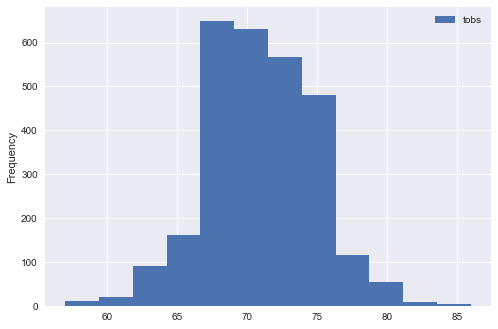

In [91]:
#create histogram
plt_data=pd.DataFrame(hist_data)
plt.figure();
plt_data.plot.hist(bins=12)

**Temperature Analysis**

In [77]:
#dependencies, date one year ago
from datetime import date
from datetime import time
import datetime

b=dt.date.today()-dt.timedelta(365)
b
res_list=[]

In [78]:
#create function calc_temps
import datetime as dt
import numpy as np
from datetime import date
from typing import Tuple

def calc_temps (start_date:str,
                end_date:str):
    s_date=datetime.datetime.strptime(start_date,"%Y-%m-%d")
    e_date=datetime.datetime.strptime(end_date,"%Y-%m-%d")
    
    qu=[
                    func.avg(Measurement.tobs),
                    func.max(Measurement.tobs),
                    func.min(Measurement.tobs)
                     ]
    result=session.query(*qu).\
                filter(Measurement.date > s_date).\
                filter(Measurement.date < e_date).all()
    res_list = list(np.ravel(result))
    
    print("Average, maximal and minimal temperature for the period:", res_list)
    return res_list

In [79]:
#apply function
start_date=('2016-8-30')
end_date=('2016-9-12')
calc_temps(start_date,end_date)


Average, maximal and minimal temperature for the period: [77.77215189873418, 84.0, 71.0]


[77.77215189873418, 84.0, 71.0]

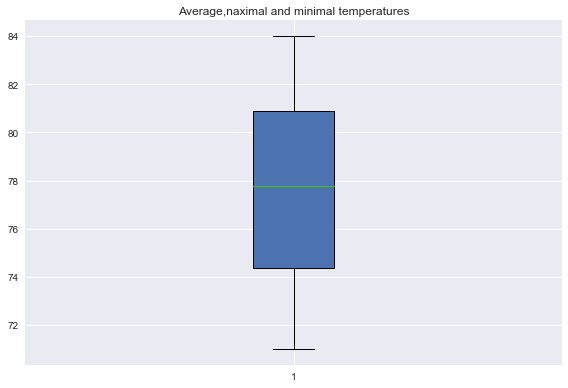

In [80]:
#create plot
import numpy as np
start_date=('2016-8-30')
end_date=('2016-9-12')
s_date=datetime.datetime.strptime(start_date,"%Y-%m-%d")
e_date=datetime.datetime.strptime(end_date,"%Y-%m-%d")
    
qu=[
                    func.avg(Measurement.tobs),
                    func.max(Measurement.tobs),
                    func.min(Measurement.tobs)
                     ]
aresult=session.query(*qu).\
                filter(Measurement.date > s_date).\
                filter(Measurement.date < e_date).all()
ares_list = list(np.ravel(aresult))
fig, ax = plt.subplots()

x = range(len(ares_list))
ax.boxplot(ares_list, patch_artist=True)
ax.set_title('Average,naximal and minimal temperatures')
fig.tight_layout()


# **Step 4 - Climate App**

In [81]:
# 1. Import Flask
from flask import Flask

In [82]:
app = Flask(__name__)


In [83]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    year_ago=dt.date.today()-dt.timedelta(365)
    presults = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date > year_ago).all()
    
    prec_all=[]
    
    for measurement in presults
        prec_dict={}
        prec_dict['date'].key()=Measurement.date
        prec_dict['tobs'].value()=Measurement.tobs
        prec_all.append(prec_dict)
    
return jsonsfy(prec_all=[]) 

@app.route("/api/v1.0/stations")
def stations():
    sresult=session.query(distinct(Measurement.station).all()
    stations_all=[] 
    for station in sresult
    stations_all.append(station) 
                          
return jsonsfy(stations_all) 
                        
                          
@app.route("/api/v1.0/tobs")
def tobs():
    tresults=session.query(Measurement.tobs).\
             filter(Measurement.date > year_ago)
     tobs_all=[]
    for tob in tresults
    tobs_all.append(tob)
                          
@app.route("/api/v1.0/<start>")
def calc01 ():
    qu=[Measurement.tobs,
                    func.avg(Measurement.tobs),
                    func.max(Measurement.tobs),
                    func.min(Measurement.tobs)
                     ]
    cresult=session.query(*qu).\
                filter(Measurement.date > star_date).al()
print("TVAG,TMAX and TMIN are:",cresult)
                          
@app.route("/api/v1.0/<start>/<end>")

calc_temps(start_date,end_date)                         
print("TVAG,TMAX and TMIN are:",res_list)    
                

SyntaxError: invalid syntax (<ipython-input-83-5d1536c2803c>, line 8)